In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns; sns.set()
import numpy as np

from sys import platform as _platform

if _platform =='linux2':
    path = '../data/data_sleep/' 
else:
    #mets ton path ici et ça devrait marcher :)
    path = ""

In [2]:
create_test = True
if(create_test):
    data=pd.read_csv(path+"input_test.csv")
else: 
    data=pd.read_csv(path+"input_train.csv")
    labels=pd.read_csv(path+"challenge_output_data_training_file_sleep_stages_classification.csv", sep=";")

In [3]:
def filt(y,low, high, freq): 
    filter_array = [i for i,f in enumerate(freq) if f>=low and f<=high]
    return np.array([y[i] for i in filter_array])

In [4]:
import re 
def make_eeg_features(train, low, high):
    fs = 250 # in Hz
    N = fs * 15
    train_eeg = train.filter(regex='EEG[0-9]*').values
    X_fft = np.fft.fft(train_eeg)
    freq = np.fft.fftfreq(N, 1./fs)
    filtered_freq = filt(freq,low,high,freq)
    X_fft = np.apply_along_axis(lambda x: filt(x,low,high,freq), 1 , 1./N * abs(X_fft))
    X_fft = pd.DataFrame(X_fft, columns= ["freq"+str(f) for f in filtered_freq])
    return X_fft

In [5]:
#X_fft = make_eeg_features(data, 0.4, 50)
#if(create_test):
#    X_fft.to_csv("data/fft_eeg_test.csv", index=False)
#else :
#    X_fft.to_csv("data/fft_eeg.csv", index=False)


In [6]:
def make_acc_features(train, low, high):
    fs = 10 #in Hz
    N = fs * 15 #number of samples
    accelaration_names = ['ACC_X.','ACC_Y.','ACC_Z.']
    result = []
    for name in accelaration_names:
        train_eeg = train.filter(regex=name+'[0-9]*').values
        X_fft = np.fft.fft(train_eeg)
        freq = np.fft.fftfreq(N, 1./fs)
        filtered_freq = filt(freq,low,high,freq)
        X_fft = np.apply_along_axis(lambda x: filt(x,low,high,freq), 1 , 1./N *abs(X_fft))
        X_fft = pd.DataFrame(X_fft, columns= [name+"freq"+str(f) for f in filtered_freq])
        result.append(X_fft)
    return pd.concat(result,axis = 1)

In [7]:
#fft_acc = make_acc_features(data, 0, 200)
#if(create_test):
#    fft_acc.to_csv("data/fft_acc_test.csv", index=False)
#else:
#    fft_acc.to_csv("data/fft_acc.csv", index=False)


In [8]:
def make_features(create_test =False, make_files = True):
    #si create_test = False: fait les trucs de train, sinon les trucs de test
    #si make_files =True, crée les fichiers dans data
    X_fft = make_eeg_features(data, 0.4, 50)
    if(make_files):
        if(create_test):
            X_fft.to_csv("data/fft_eeg_test.csv", index=False)
        else :
            X_fft.to_csv("data/fft_eeg.csv", index=False)
    
    fft_acc = make_acc_features(data, 0, 200)
    if(make_files):    
        if(create_test):
            fft_acc.to_csv("data/fft_acc_test.csv", index=False)
        else:
            fft_acc.to_csv("data/fft_acc.csv", index=False)
    return X_fft, fft_acc

make_features(create_test = True)

(         freq0.4  freq0.466666666667  freq0.533333333333    freq0.6  \
 0       0.369788            0.057286            0.167872   0.541040   
 1       2.103583            2.591920            2.237481   0.604488   
 2       0.429960            1.027026            0.967975   0.929622   
 3       0.474867            1.225553            0.351758   0.186687   
 4       6.532762            5.896757            8.322209   7.980773   
 5       0.434369            0.160586            0.711231   1.403510   
 6       0.587336            1.118348            1.152950   0.102669   
 7       1.818588            2.565140            1.089894   1.344216   
 8       0.494436            3.167114            3.069268   0.718483   
 9       0.413518            1.144871            0.136679   0.576738   
 10     17.550638            6.065122           11.355105   6.990359   
 11      2.047610            1.652285            0.384620   0.180048   
 12      0.855992            1.067072            0.235201   0.65

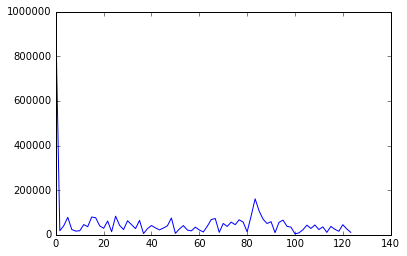

In [50]:
freq = np.fft.fftfreq(15*10, 1./250)
plt.plot(freq[0:75],result.values[0][0:75])

In [26]:
X_fft.values[0].shape,filt(np.fft.fftfreq(15*250, 1./250),0.4,50,np.fft.fftfreq(15*250, 1./250)).shape

((745,), (745,))

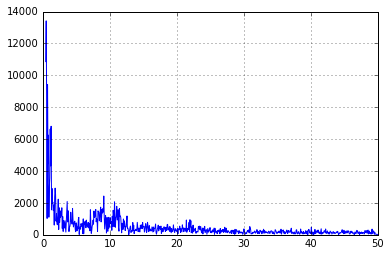

In [36]:
freq = np.fft.fftfreq(15*250, 1./250)
plt.plot(filt(freq,0.4,50,freq),np.abs(X_fft.values[31]))
plt.grid()
plt.show()